In [1]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [3]:
import multiprocessing

multiprocessing.cpu_count()

12

In [4]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
EPOCH = 100
learning_rate = 0.0002 

In [6]:
#load the train mri data
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/Training/MRI')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/Training/MRI')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [7]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [8]:
#verify the shape matches the pytorch standard
train_mri.shape

(272, 1, 256, 256)

In [9]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

torch.Size([272, 1, 256, 256])

In [10]:
#load the train pet data
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/Training/PET')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/Training/PET')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [11]:
#expand the dimension to add the channel
train_pet = np.expand_dims(train_pet,axis=1)

In [12]:
#verify the shape matches the pytorch standard
train_pet.shape

(272, 1, 256, 256)

In [13]:
#convert the PET training data to pytorch tensor
train_pet_tensor = torch.from_numpy(train_pet).float()
train_pet_tensor.shape

torch.Size([272, 1, 256, 256])

In [14]:
#define the generator network
class FusionDN(nn.Module):
    def  __init__(self):
        super(FusionDN, self).__init__()
        ##### Encoder Layer 1#####
        self.layer1 = nn.Sequential( #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())        
        ##### Encoder Layer 2#####
        self.layer2 = nn.Sequential( 
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())    
        ##### Encoder Layer 3#####
        self.layer3 = nn.Sequential(
                         nn.Conv2d(in_channels=96, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())     
        ##### Encoder Layer 4#####
        self.layer4 = nn.Sequential( 
                         nn.Conv2d(in_channels=144, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())      
        ##### Encoder Layer 5#####
        self.layer5 = nn.Sequential( 
                         nn.Conv2d(in_channels=192, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())        
        
        ##### Decoder Layer 1#####
        self.layer6 = nn.Sequential( 
                         nn.Conv2d(in_channels=240, out_channels=240, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(240),
                         nn.ReLU())     
        ##### Decoder Layer 2#####
        self.layer7 = nn.Sequential( 
                         nn.Conv2d(in_channels=240, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(128),
                         nn.ReLU())       
        ##### Decoder Layer 3#####
        self.layer8 = nn.Sequential( 
                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(64),
                         nn.ReLU())       
        ##### Decoder Layer 4#####
        self.layer9 = nn.Sequential(
                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
                         nn.Tanh())         


    def forward(self, x, y):
        #Encoder 
        xy = torch.cat((x,y),1)
        x1 = self.layer1(xy)
        x2 = self.layer2(x1)
        concat1 = torch.cat((x1,x2),1)
        x3 = self.layer3(concat1)
        concat2 = torch.cat((x3,concat1),1)
        x4 = self.layer4(concat2)
        concat3 = torch.cat((x4,concat2),1)
        x5 = self.layer5(concat3)
        concat4 = torch.cat((x5,concat3),1)
        #Decoder
        x6 = self.layer6(concat4)
        x7 = self.layer7(x6)
        x8 = self.layer8(x7)
        fused = self.layer9(x8)
        return fused

gen = FusionDN().to(device)
gen = gen.float()
print(gen)

FusionDN(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (laye

In [15]:
#define the optimizers and loss functions 
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)   # optimize all cnn parameters
l2_loss       = nn.MSELoss() #MSEloss

In [16]:
# perform the training
counter = 0
start_time = time.time()
lamda = 1
ep_ssim_mri_loss = []
ep_ssim_pet_loss = []
ep_total_loss =[]
for epoch in range(EPOCH):
    ssim_mri_Loss = []
    ssim_pet_Loss   = []
    total_Loss = []
    #run batch images
    batch_idxs = 272 // batch_size
    for idx in range(0, batch_idxs):
        #ge tthe mri and pet batches
        b_x = train_mri_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        b_y = train_pet_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        
        counter += 1  
        #clear the generator gradients
        gen_optimizer.zero_grad()    

        #get a fused image from generator
        output = gen(b_x,b_y)               # gen output   
        
        #define the generator loss
        ssim_loss_mri = 1 - ssim(output, b_x,data_range=1)
        ssim_loss_pet = 1 - ssim(output, b_y,data_range=1)
        total_loss = ssim_loss_mri + ssim_loss_pet

        #update the generator
        total_loss.backward(retain_graph=True)  # backpropagation, compute gradients
        gen_optimizer.step()                # apply gradients

        #store all the loss values at each epoch
        ssim_mri_Loss.append(ssim_loss_mri.item())
        ssim_pet_Loss.append(ssim_loss_pet.item())
        total_Loss.append(total_loss.item())
        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], mri_ssim_loss: [%.8f], pet_ssim_loss: [%.8f], total_loss: [%.8f]"
            %(epoch, counter, ssim_loss_mri, ssim_loss_pet, total_loss))
    
    av_ssim_mri_loss = np.average(ssim_mri_Loss)
    ep_ssim_mri_loss.append(av_ssim_mri_loss)
    
    av_ssim_pet_loss = np.average(ssim_pet_Loss)
    ep_ssim_pet_loss.append(av_ssim_pet_loss)
    
    av_total_loss = np.average(total_Loss)
    ep_total_loss.append(av_total_loss)
    
    if(epoch == EPOCH -1):
        #Save a checkpoint
        torch.save(gen, 'C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FusionDN/checkpoint.pth') 

Epoch: [ 0],step: [100], mri_ssim_loss: [0.11071545], pet_ssim_loss: [0.21424025], total_loss: [0.32495570]
Epoch: [ 0],step: [200], mri_ssim_loss: [0.51383954], pet_ssim_loss: [0.55729467], total_loss: [1.07113421]
Epoch: [ 1],step: [300], mri_ssim_loss: [0.20651406], pet_ssim_loss: [0.32073182], total_loss: [0.52724588]
Epoch: [ 1],step: [400], mri_ssim_loss: [0.06651604], pet_ssim_loss: [0.17214125], total_loss: [0.23865730]
Epoch: [ 1],step: [500], mri_ssim_loss: [0.39758134], pet_ssim_loss: [0.48077327], total_loss: [0.87835461]
Epoch: [ 2],step: [600], mri_ssim_loss: [0.20298654], pet_ssim_loss: [0.39793730], total_loss: [0.60092384]
Epoch: [ 2],step: [700], mri_ssim_loss: [0.20913410], pet_ssim_loss: [0.22310942], total_loss: [0.43224353]
Epoch: [ 2],step: [800], mri_ssim_loss: [0.13176024], pet_ssim_loss: [0.21142554], total_loss: [0.34318578]
Epoch: [ 3],step: [900], mri_ssim_loss: [0.16569251], pet_ssim_loss: [0.30782533], total_loss: [0.47351784]
Epoch: [ 3],step: [1000], mr

Epoch: [28],step: [7700], mri_ssim_loss: [0.09978670], pet_ssim_loss: [0.22424573], total_loss: [0.32403243]
Epoch: [28],step: [7800], mri_ssim_loss: [0.19085556], pet_ssim_loss: [0.27585250], total_loss: [0.46670806]
Epoch: [29],step: [7900], mri_ssim_loss: [0.19424969], pet_ssim_loss: [0.14691728], total_loss: [0.34116697]
Epoch: [29],step: [8000], mri_ssim_loss: [0.09922600], pet_ssim_loss: [0.15398890], total_loss: [0.25321490]
Epoch: [29],step: [8100], mri_ssim_loss: [0.19564581], pet_ssim_loss: [0.17889017], total_loss: [0.37453598]
Epoch: [30],step: [8200], mri_ssim_loss: [0.27127719], pet_ssim_loss: [0.32707828], total_loss: [0.59835547]
Epoch: [30],step: [8300], mri_ssim_loss: [0.06502897], pet_ssim_loss: [0.10143495], total_loss: [0.16646391]
Epoch: [30],step: [8400], mri_ssim_loss: [0.13880920], pet_ssim_loss: [0.25606698], total_loss: [0.39487618]
Epoch: [31],step: [8500], mri_ssim_loss: [0.12310803], pet_ssim_loss: [0.38386905], total_loss: [0.50697708]
Epoch: [31],step: [

Epoch: [55],step: [15200], mri_ssim_loss: [0.14153689], pet_ssim_loss: [0.24807972], total_loss: [0.38961661]
Epoch: [56],step: [15300], mri_ssim_loss: [0.12194085], pet_ssim_loss: [0.38253391], total_loss: [0.50447476]
Epoch: [56],step: [15400], mri_ssim_loss: [0.15660608], pet_ssim_loss: [0.22621810], total_loss: [0.38282418]
Epoch: [56],step: [15500], mri_ssim_loss: [0.18736345], pet_ssim_loss: [0.19159418], total_loss: [0.37895763]
Epoch: [57],step: [15600], mri_ssim_loss: [0.09267479], pet_ssim_loss: [0.18481570], total_loss: [0.27749050]
Epoch: [57],step: [15700], mri_ssim_loss: [0.17687851], pet_ssim_loss: [0.38731885], total_loss: [0.56419736]
Epoch: [58],step: [15800], mri_ssim_loss: [0.18980485], pet_ssim_loss: [0.26196939], total_loss: [0.45177424]
Epoch: [58],step: [15900], mri_ssim_loss: [0.10852635], pet_ssim_loss: [0.12687325], total_loss: [0.23539960]
Epoch: [58],step: [16000], mri_ssim_loss: [0.31283152], pet_ssim_loss: [0.41032398], total_loss: [0.72315550]
Epoch: [59

Epoch: [83],step: [22700], mri_ssim_loss: [0.10585606], pet_ssim_loss: [0.12854558], total_loss: [0.23440164]
Epoch: [83],step: [22800], mri_ssim_loss: [0.31524688], pet_ssim_loss: [0.39631349], total_loss: [0.71156037]
Epoch: [84],step: [22900], mri_ssim_loss: [0.26260918], pet_ssim_loss: [0.17998803], total_loss: [0.44259721]
Epoch: [84],step: [23000], mri_ssim_loss: [0.12296432], pet_ssim_loss: [0.14118403], total_loss: [0.26414835]
Epoch: [84],step: [23100], mri_ssim_loss: [0.14444518], pet_ssim_loss: [0.20667756], total_loss: [0.35112274]
Epoch: [85],step: [23200], mri_ssim_loss: [0.10310531], pet_ssim_loss: [0.21192491], total_loss: [0.31503022]
Epoch: [85],step: [23300], mri_ssim_loss: [0.14964455], pet_ssim_loss: [0.31452811], total_loss: [0.46417266]
Epoch: [86],step: [23400], mri_ssim_loss: [0.14953238], pet_ssim_loss: [0.22096723], total_loss: [0.37049961]
Epoch: [86],step: [23500], mri_ssim_loss: [0.10552752], pet_ssim_loss: [0.14586848], total_loss: [0.25139600]
Epoch: [86

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FusionDN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
l1 = np.asarray(ep_ssim_mri_loss)
l2 = np.asarray(ep_ssim_pet_loss)

In [20]:
h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Loss curves/FusionDN/H5 Files/Loss_SSIM_PET.h5', 'w')
h5f.create_dataset('PET_dataset', data=l2)
h5f.close()

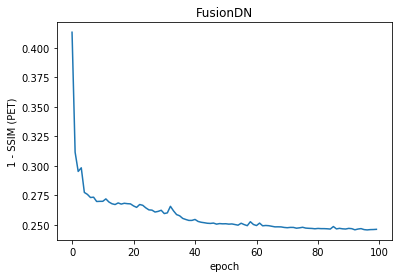

In [22]:
plt.plot(l2)
plt.xlabel('epoch')
plt.ylabel('1 - SSIM (PET)')
plt.title('FusionDN')
plt.savefig('C:/Users/horan/Desktop/FuseVis/Loss curves/FusionDN/Loss curves/Loss_SSIM_PET.png', bbox_inches = 'tight',pad_inches = 0, dpi=200)

In [23]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [24]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(1, 1, 256, 256)

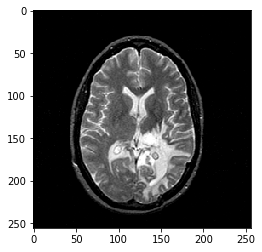

In [25]:
#verify the test mri image
#test_mri = test_mri[0,:,:,:]
#test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')
#plt.savefig('MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [26]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
test_mri_tensor = test_mri_tensor.to(device)
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [27]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [28]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

(1, 1, 256, 256)

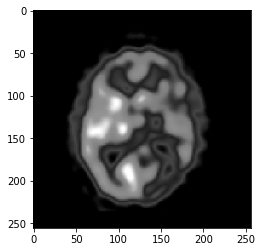

In [29]:
#verify the test pet image
#test_pet = test_pet[2,:,:,:]
#test_pet = np.expand_dims(test_pet,axis=0)
plt.imshow(test_pet[0,0,:,:],'gray')

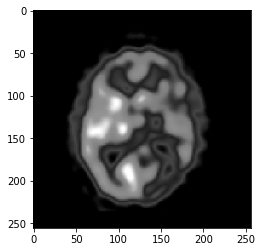

In [30]:
plt.imshow(test_pet[0,0,:,:],'gray')
#plt.savefig('PET.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [31]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
test_pet_tensor = test_pet_tensor.to(device)
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [32]:
#load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FusionDN/checkpoint.pth')
gen.eval()

FusionDN(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (laye

In [33]:
#predicted the fused image
fused = gen(test_mri_tensor.to(device), test_pet_tensor.to(device))
fused_numpy = fused.data.cpu().numpy()

In [34]:
fused.shape

torch.Size([1, 1, 256, 256])

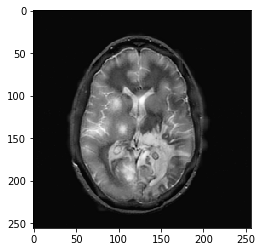

In [35]:
#verify the output image
plt.imshow(fused_numpy[0,0,:,:],'gray')
#plt.savefig('Fused.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [37]:
imageio.imwrite('C:/Users/horan/Desktop/FuseVis/Fused/FusionDN/Fused.png',np.uint8(cv2.normalize(fused_numpy[0,0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

In [38]:
#calculate the guidance image for MRI and PET wrt to the fused image
time1 = time.time()
count = 0 
guide_fuse_mri = np.zeros((256,256),dtype=float)
guide_fuse_pet = np.zeros((256,256),dtype=float)

for y_coord in range(0,256):
    for x_coord in range(0,256):
        jacob_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_mri = np.squeeze(jacob_fuse_mri.data.cpu().numpy())  
        guide_fuse_mri[y_coord,x_coord] = jacob_numpy_mri[y_coord,x_coord]
        jacob_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_pet = np.squeeze(jacob_fuse_pet.data.cpu().numpy())  
        guide_fuse_pet[y_coord,x_coord] = jacob_numpy_pet[y_coord,x_coord]
        count += 1
        if count % 100 == 0:
            print('Count is %d' %count)
time2 = time.time()
print('Time taken to compute is %d seconds' %(time2-time1))

Count is 100
Count is 200
Count is 300
Count is 400
Count is 500
Count is 600
Count is 700
Count is 800
Count is 900
Count is 1000
Count is 1100
Count is 1200
Count is 1300
Count is 1400
Count is 1500
Count is 1600
Count is 1700
Count is 1800
Count is 1900
Count is 2000
Count is 2100
Count is 2200
Count is 2300
Count is 2400
Count is 2500
Count is 2600
Count is 2700
Count is 2800
Count is 2900
Count is 3000
Count is 3100
Count is 3200
Count is 3300
Count is 3400
Count is 3500
Count is 3600
Count is 3700
Count is 3800
Count is 3900
Count is 4000
Count is 4100
Count is 4200
Count is 4300
Count is 4400
Count is 4500
Count is 4600
Count is 4700
Count is 4800
Count is 4900
Count is 5000
Count is 5100
Count is 5200
Count is 5300
Count is 5400
Count is 5500
Count is 5600
Count is 5700
Count is 5800
Count is 5900
Count is 6000
Count is 6100
Count is 6200
Count is 6300
Count is 6400
Count is 6500
Count is 6600
Count is 6700
Count is 6800
Count is 6900
Count is 7000
Count is 7100
Count is 7200
C

Count is 55500
Count is 55600
Count is 55700
Count is 55800
Count is 55900
Count is 56000
Count is 56100
Count is 56200
Count is 56300
Count is 56400
Count is 56500
Count is 56600
Count is 56700
Count is 56800
Count is 56900
Count is 57000
Count is 57100
Count is 57200
Count is 57300
Count is 57400
Count is 57500
Count is 57600
Count is 57700
Count is 57800
Count is 57900
Count is 58000
Count is 58100
Count is 58200
Count is 58300
Count is 58400
Count is 58500
Count is 58600
Count is 58700
Count is 58800
Count is 58900
Count is 59000
Count is 59100
Count is 59200
Count is 59300
Count is 59400
Count is 59500
Count is 59600
Count is 59700
Count is 59800
Count is 59900
Count is 60000
Count is 60100
Count is 60200
Count is 60300
Count is 60400
Count is 60500
Count is 60600
Count is 60700
Count is 60800
Count is 60900
Count is 61000
Count is 61100
Count is 61200
Count is 61300
Count is 61400
Count is 61500
Count is 61600
Count is 61700
Count is 61800
Count is 61900
Count is 62000
Count is 6

In [39]:
h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/H5 Files/Jacobian_MRI.h5', 'w')
h5f.create_dataset('Jacob_MRI_dataset', data=guide_fuse_mri)
h5f.close()

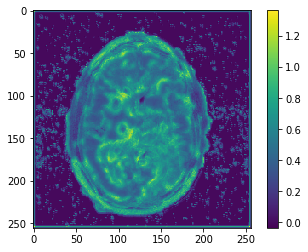

In [40]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_MRI_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [41]:
h5f = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/H5 Files/Jacobian_PET.h5', 'w')
h5f.create_dataset('Jacob_PET_dataset', data=guide_fuse_pet)
h5f.close()

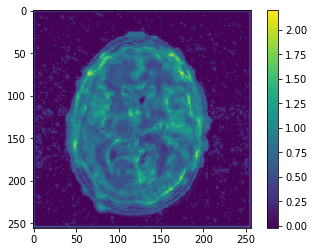

In [42]:
plt.imshow(guide_fuse_pet,cmap='viridis')
plt.colorbar()
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_PET_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [43]:
#define overlay images
fused_RGB = np.zeros((256,256,3),dtype=float)
mri_RGB   = np.zeros((256,256,3),dtype=float)
pet_RGB   = np.zeros((256,256,3),dtype=float)

In [44]:
fused_RGB[:,:,0]  = guide_fuse_mri 
fused_RGB[:,:,1]  = guide_fuse_pet 
fused_RGB[:,:,2]  = fused_numpy[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


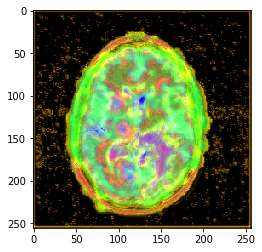

In [45]:
plt.imshow(fused_RGB)
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Fused_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [46]:
mri_RGB[:,:,0]  = guide_fuse_mri
mri_RGB[:,:,1]  = guide_fuse_pet 
mri_RGB[:,:,2]  = test_mri[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


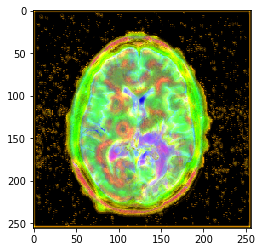

In [47]:
plt.imshow(mri_RGB)
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/MRI_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [48]:
pet_RGB[:,:,0]  = guide_fuse_mri
pet_RGB[:,:,1]  = guide_fuse_pet 
pet_RGB[:,:,2]  = test_pet[0,0,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


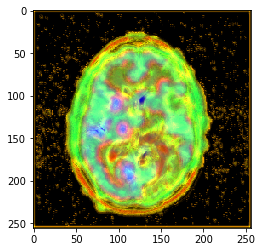

In [49]:
plt.imshow(pet_RGB)
plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/PET_RGB_DPI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [53]:
#define the window
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')


#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame
canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame


#define the canvas
canvas = Canvas(canvasframe, width=1800, height=920, bg = 'white')
canvas.grid(row=0, column=0)

#Insert fused image to the canvas
img_fused = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/FusionDN/Fused.png") # load the image
canvas.create_image(0, 0, image=img_fused, anchor=NW)

#Insert MRI image to the canvas
img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
canvas.create_image(600, 0, image=img_mri, anchor=NW)

#Insert PET image to the canvas
img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
canvas.create_image(1200, 0, image=img_pet, anchor=NW)

def start_mouseover():  # function called when user clicks the button 
    # link the function to the left-mouse-click event
    canvas.bind("<B1-Motion>", Coordinates)

def Coordinates(event): # function called when left-mouse-button is clicked with a mouseover
    x_coord = event.x  # save x and y coordinates selected by the user   
    y_coord = event.y
    print('mouse position is at' + '(' + str(y_coord) + ',' + str(x_coord) + ')', end='\r')
    #display the output MRI Jacobian image
    #img_MR_out = ImageTk.PhotoImage(file ='C:/Users/cgvadmin/Desktop/FuseVis/Fused_MRI/im_' + str(y_coord) + '_' + str(x_coord) + '.png') # load the image
    jacobian_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
    jacobian_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
    
    jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
    jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
    
    x_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 0)))
    y_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 1)))
    minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
    zoom_im_mri = jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri] 
    
    x_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 0)))
    y_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 1)))
    minx_pet, maxx_pet, miny_pet, maxy_pet = np.min(x_pet), np.max(x_pet), np.min(y_pet), np.max(y_pet)  #return min and max coordinates
    zoom_im_pet = jacob_val_pet[miny_pet:maxy_pet,minx_pet:maxx_pet] 
    
    plt.imshow(fused_numpy[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom Fused')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_Fused.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out11 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_Fused.png')
    canvas.create_image(300,5,image=im_out11,anchor=NW)
    canvas.image11 = im_out11
    plt.tight_layout()
    
    plt.imshow(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom MRI')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out12 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_MRI.png')
    canvas.create_image(900,5,image=im_out12,anchor=NW)
    canvas.image12 = im_out12
    plt.tight_layout()
    
    plt.imshow(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom PET')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out13 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_PET.png')
    canvas.create_image(1500,5,image=im_out13,anchor=NW)
    canvas.image13 = im_out13
    plt.tight_layout()
    
    plt.imshow(jacob_val_mri,cmap='viridis', aspect ='equal')
    plt.title('Jacobian (Fused wrt MRI)')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Jacob_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out1 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Jacob_Fused_MRI.png')
    canvas.create_image(40,320,image=im_out1,anchor=NW)
    canvas.image1 = im_out1
    #plt.tight_layout()
    
    #f.add_subplot(1,5,2)
    plt.imshow(zoom_im_mri,cmap='viridis',aspect ='equal')
    plt.title('Zoom Jacobian (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_Jacob_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out2 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_Jacob_MRI.png')
    canvas.create_image(380,320,image=im_out2,anchor=NW)
    canvas.image2 = im_out2
    
    #f.add_subplot(1,5,3)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    plt.plot(jacob_val_mri[y_coord,x_coord],jacob_val_pet[y_coord,x_coord],'-ro')
    plt.xlabel('MRI pixel score (Fused wrt MRI)')
    plt.ylabel('PET pixel score (Fused wrt PET)')
    plt.title('Mouse position at: (' + str(y_coord) + ',' + str(x_coord) + ')')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Pixel_intensities.png', bbox_inches = 'tight',pad_inches = 0.1)
    plt.close()
    im_out3 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Pixel_intensities.png')
    canvas.create_image(750,320,image=im_out3,anchor=NW)
    canvas.image3 = im_out3
    
    #f.add_subplot(1,5,4)
    plt.imshow(jacob_val_pet,cmap='viridis',aspect ='equal')
    plt.title('Jacobian (Fused wrt PET)')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Jacob_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out4 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Jacob_Fused_PET.png')
    canvas.create_image(1110,320,image=im_out4,anchor=NW)
    canvas.image4 = im_out4
    #plt.tight_layout()
    
    #f.add_subplot(1,5,5)
    plt.imshow(zoom_im_pet,cmap='viridis',aspect ='equal')
    plt.title('Zoomed Jacobian (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_Jacob_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Zoom_Jacob_PET.png')
    canvas.create_image(1450,320,image=im_out5,anchor=NW)
    canvas.image5 = im_out5

    plt.imshow(guide_fuse_mri,cmap='viridis')
    plt.title('Guidance (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out6 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_MRI.png')
    canvas.create_image(100,650,image=im_out6,anchor=NW)
    canvas.image6 = im_out6
    
    plt.imshow(fused_RGB)
    plt.title('R=I1 G=I2 B=Fused')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out8 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Fused_RGB.png')
    canvas.create_image(420,650,image=im_out8,anchor=NW)
    canvas.image8 = im_out8
    
    plt.imshow(mri_RGB)
    plt.title('R=I1 G=I2 B=MRI')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/MRI_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out9 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/MRI_RGB.png')
    canvas.create_image(740,650,image=im_out9,anchor=NW)
    canvas.image9 = im_out9
    
    plt.imshow(pet_RGB)
    plt.title('R=I1 G=I2 B=PET')
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/PET_RGB.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out10 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/PET_RGB.png')
    canvas.create_image(1100,650,image=im_out10,anchor=NW)
    canvas.image10 = im_out10
    
    plt.imshow(guide_fuse_pet,cmap='viridis')
    plt.title('Guidance (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out7 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_PET.png')
    canvas.create_image(1400,650,image=im_out7,anchor=NW)
    canvas.image7 = im_out7
    
    radius = 5
    i = canvas.create_oval(x_coord-radius, y_coord-radius, x_coord+radius, y_coord+radius, fill = 'red')
    canvas.after(20,canvas.delete,i)

# insert button to the middleframe and link it to "Start Mouseover"
button_start_mouseover = Button(buttonframe, text="Start Mouseover",command=start_mouseover)
button_start_mouseover.grid(row=1, column=0, pady=0)


root.mainloop()  #keep the GUI open

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
